<a href="https://colab.research.google.com/github/fionawesonga/movie-recommendation-AI/blob/main/Fiona_RecommendationMovies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
try:
    movies = pd.read_csv('/content/drive/MyDrive/DAS Assignment/IMDB top 1000.csv') # Corrected file path
except FileNotFoundError:
    print("Error: 'IMDB top 1000.csv' not found. Please ensure the file path is correct.")
    exit()

In [ ]:
def combine_meta(row):
    return (
        f"Title: {row['Title']}. "
        f"Genre: {row['Genre']}. "
        f"Plot: {row['Description']}. "
        f"Stars: {row['Cast']}. "
        f"Rating: {row['Rate']}"
    )

movies['MetaText'] = movies.apply(combine_meta, axis=1)
movies['movie_id'] = movies.index.astype(str)

print(movies[['movie_id', 'MetaText']].head())


  movie_id                                           MetaText
0        0  Title: 1. The Shawshank Redemption (1994). Gen...
1        1  Title: 2. The Godfather (1972). Genre: Crime, ...
2        2  Title: 3. The Dark Knight (2008). Genre: Actio...
3        3  Title: 4. The Godfather: Part II (1974). Genre...
4        4  Title: 5. The Lord of the Rings: The Return of...


In [ ]:
# Check for missing values in key columns
print(movies[['Title', 'Genre', 'Description', 'Cast', 'Rate']].isnull().sum())

# Drop rows missing critical data (e.g., Title or Description)
movies = movies.dropna(subset=['Title', 'Description'])

# For other columns like Genre, Cast, Rate, fill missing with placeholder or mode/mean if appropriate
movies['Genre'] = movies['Genre'].fillna('Unknown')
movies['Cast'] = movies['Cast'].fillna('Unknown')
movies['Rate'] = pd.to_numeric(movies['Rate'], errors='coerce')
movies['Rate'] = movies['Rate'].fillna(movies['Rate'].mean())

# Remove duplicate rows if any
movies = movies.drop_duplicates()

# Strip whitespace for string columns
for col in ['Title', 'Genre', 'Description', 'Cast']:
    movies[col] = movies[col].str.strip()

# Confirm cleaning results
print("After cleaning:")
print(movies[['Title', 'Genre', 'Description', 'Cast', 'Rate']].info())

Title          0
Genre          0
Description    0
Cast           0
Rate           0
dtype: int64
After cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        1000 non-null   object 
 1   Genre        1000 non-null   object 
 2   Description  1000 non-null   object 
 3   Cast         1000 non-null   object 
 4   Rate         1000 non-null   float64
dtypes: float64(1), object(4)
memory usage: 39.2+ KB
None


/tmp/ipython-input-3793462226.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


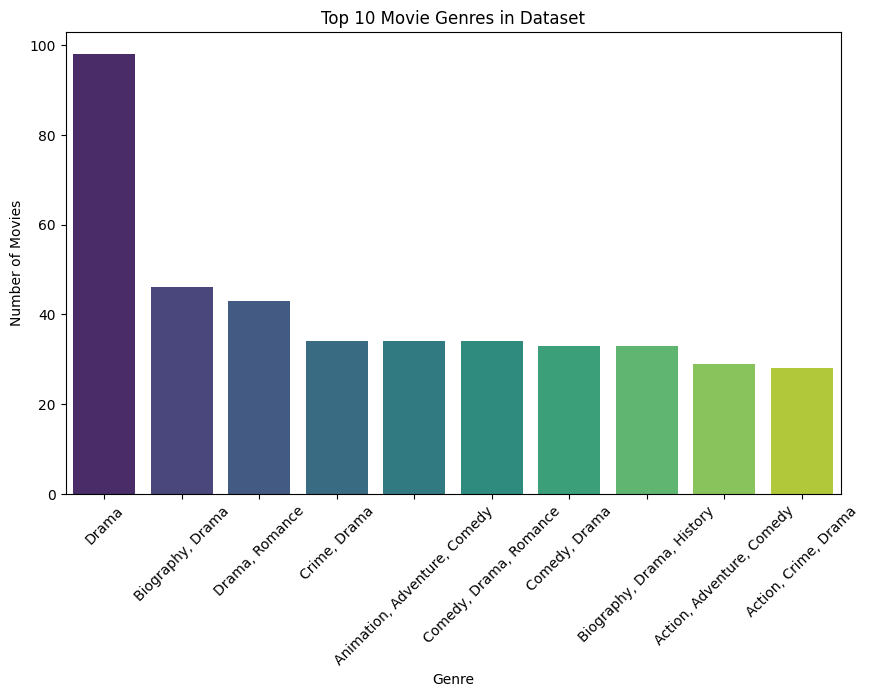

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simple bar plot of top genres
plt.figure(figsize=(10, 6))
genre_counts = movies['Genre'].value_counts().head(10)
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title("Top 10 Movie Genres in Dataset")
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()



In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize chunker: 512 token max per chunk, 30 token overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=30
)

# Apply chunking to the MetaText column list of all movies combined
all_meta_text = "\n".join(movies['MetaText'].tolist())
movie_chunks = text_splitter.split_text(all_meta_text)

print(f"Number of chunks created: {len(movie_chunks)}")
print(f"Example chunk preview:\n{movie_chunks[0][:500]}")

Number of chunks created: 992
Example chunk preview:
Title: 1. The Shawshank Redemption (1994). Genre: Drama. Plot: Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.. Stars: Director: Frank Darabont | Stars: Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler. Rating: 9.3


In [ ]:

duplicate_rows = movies.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [ ]:
!pip install sentence-transformers chromadb langchain_community langchain sentence_transformers langchain_huggingface


In [ ]:
from sentence_transformers import SentenceTransformer

# Load the Hugging Face embedding model (all-MiniLM-L6-v2 is a good balance of speed/quality)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the movie chunks
chunk_embeddings = model.encode(movie_chunks, show_progress_bar=True)

# Display the first 5 embeddings as an example
print("Example of the first 5 embeddings:")
print(chunk_embeddings[:5])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Example of the first 5 embeddings:
[[-0.10725535 -0.04219348 -0.09401728 ...  0.00914073 -0.04082022
  -0.03237154]
 [-0.09604132 -0.0150156  -0.07792213 ...  0.03976613  0.0048803
  -0.04686929]
 [-0.00742459 -0.05675209 -0.09207636 ... -0.02611339  0.02236469
   0.06081755]
 [-0.04276575 -0.00292667 -0.04099254 ...  0.0377178   0.00110665
  -0.00792344]
 [-0.08652384 -0.06514711 -0.03998774 ... -0.01783666 -0.05917855
   0.02265724]]


In [ ]:
from chromadb import PersistentClient

persist_dir = '/content/drive/MyDrive/chroma_db'
client = PersistentClient(path=persist_dir)

In [ ]:
# First, install the chromadb library if you haven't already
%pip install chromadb langchain-community langchain-chroma

In [ ]:
chunk_ids = [str(i) for i in range(len(movie_chunks))]

# Create a ChromaDB collection
collection = client.get_or_create_collection(name="movie_chunks")

collection.add(documents=movie_chunks, embeddings=chunk_embeddings.tolist(), ids=chunk_ids)

print("Vector store populated successfully!")

Vector store populated successfully!


In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings


# Setup embeddings and Chroma vector store pointing to your persistent directory
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vector_store = Chroma(
    persist_directory='/content/drive/MyDrive/chroma_db',
    embedding_function=embedding_function,
    collection_name="movie_chunks"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

print("Retriever ready.")

Retriever ready.


In [ ]:
# Define prompt template with consistent input variable names
prompt_template = """
You are a movie recommendation assistant.

Analyze the following movie descriptions provided as context:
{context}

Based on the user's request: "{input}", provide a clear, concise, and well-structured recommendation explanation.

Your answer should be in natural, human-readable form and focus on the following aspects:

1.  **Genre Alignment:** Explain how the recommended movies align with the genres mentioned in the user's request.
2.  **Star Relevance:** Highlight any relevant stars from the recommended movies that might appeal to the user based on their request.
3.  **Plot Similarity:** Describe how the plots of the recommended movies are similar to what the user is looking for.

Structure your answer clearly using bullet points or numbered lists for each of the three aspects.

Do NOT repeat the context or the user's request in your answer. Only provide the final recommendation explanation.

Answer:
"""

In [ ]:
PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "input"])

# Set up HuggingFace GPT2 pipeline and wrap in LangChain LLM wrapper
llm_pipeline = pipeline(
    "text-generation",
    model="gpt2",
    max_new_tokens=256,  # generate up to 256 new tokens
    temperature=0.4,
    pad_token_id=50256,
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

# Create stuff documents chain to combine retrieved docs into prompt for the LLM
qa_chain = create_stuff_documents_chain(llm=llm, prompt=PROMPT)

print("Stuff documents chain ready.")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Stuff documents chain ready.


In [ ]:
from langchain.chains import create_retrieval_chain

# Create retrieval chain linking retriever + documents chain
retrieval_chain = create_retrieval_chain(
    retriever=retriever,
    combine_docs_chain=qa_chain
)

print("Retrieval chain ready.")

# Example query to get a recommendation
query = "I want to watch a crime thriller with deep story and strong performances"

result = retrieval_chain.invoke({"input": query})

print("Result keys:", result.keys())   # Inspect keys present

# Print the full result to understand structure
print(result)

# Try printing the common output keys
if "output_text" in result:
    print(result["output_text"])
elif "output" in result:
    print(result["output"])
elif "result" in result:
    print(result["result"])
else:
    # Just print the first available value
    print(next(iter(result.values())))

Retrieval chain ready.
Result keys: dict_keys(['input', 'context', 'answer'])
{'input': 'I want to watch a crime thriller with deep story and strong performances', 'context': [Document(id='125', metadata={}, page_content='Title: 126. M (1931). Genre: Crime, Mystery, Thriller. Plot: When the police in a German city are unable to catch a child-murderer, other criminals join in the manhunt.. Stars: Director: Fritz Lang | Stars: Peter Lorre, Ellen Widmann, Inge Landgut, Otto Wernicke. Rating: 8.3'), Document(id='132', metadata={}, page_content='Title: 133. Talvar (2015). Genre: Crime, Drama, Mystery. Plot: An experienced investigator confronts several conflicting theories about the perpetrators of a violent double homicide.. Stars: Director: Meghna Gulzar | Stars: Irrfan Khan, Konkona Sen Sharma, Neeraj Kabi, Sohum Shah. Rating: 8.2'), Document(id='217', metadata={}, page_content="Title: 220. Prisoners (2013). Genre: Crime, Drama, Mystery. Plot: When Keller Dover's daughter and her friend 

In [ ]:
import re

def extract_pattern(text, pattern):
    match = re.search(pattern, text)
    return match.group(1) if match else "Unknown"

# Extract cleaned movie info from retrieved docs
print("Movies in recommendation context:")
for doc in result["context"]:
    content = doc.page_content
    title = extract_pattern(content, r"Title: (.+?)\.")
    year = extract_pattern(title, r"\((\d{4})\)")
    stars = extract_pattern(content, r"Stars: (.+?)\.")
    print(f"{title} ({year}), Stars: {stars}")


Movies in recommendation context:
126 (Unknown), Stars: Director: Fritz Lang | Stars: Peter Lorre, Ellen Widmann, Inge Landgut, Otto Wernicke
133 (Unknown), Stars: Director: Meghna Gulzar | Stars: Irrfan Khan, Konkona Sen Sharma, Neeraj Kabi, Sohum Shah
220 (Unknown), Stars: Director: Denis Villeneuve | Stars: Hugh Jackman, Jake Gyllenhaal, Viola Davis, Melissa Leo


In [ ]:
%pip install --upgrade --quiet  langchain-chroma

In [ ]:
%pip install langchain-huggingface

import re
from langchain.chains import create_retrieval_chain
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings


def extract_pattern(text, pattern):
    match = re.search(pattern, text)
    return match.group(1) if match else "Unknown"

# Define prompt template with consistent input variable names
prompt_template = """
You are a movie recommendation assistant.

Analyze the following movie descriptions provided as context:
{context}

Based on the user's request: "{input}", provide a clear, concise, and well-structured recommendation explanation.

Your answer should be in natural, human-readable form and focus on the following aspects:

1.  **Genre Alignment:** Explain how the recommended movies align with the genres mentioned in the user's request.
2.  **Star Relevance:** Highlight any relevant stars from the recommended movies that might appeal to the user based on their request.
3.  **Plot Similarity:** Describe how the plots of the recommended movies are similar to what the user is looking for.

Structure your answer clearly using bullet points or numbered lists for each of the three aspects.

Do NOT repeat the context or the user's request in your answer. Only provide the final recommendation explanation.

Answer:
"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "input"])

# Set up HuggingFace GPT2 pipeline and wrap in LangChain LLM wrapper
llm_pipeline = pipeline(
    "text-generation",
    model="gpt2",
    max_new_tokens=256,  # generate up to 256 new tokens
    temperature=0.4,
    pad_token_id=50256,
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

# Create stuff documents chain to combine retrieved docs into prompt for the LLM
qa_chain = create_stuff_documents_chain(llm=llm, prompt=PROMPT)

# Setup embeddings and Chroma vector store pointing to your persistent directory
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vector_store = Chroma(
    persist_directory='/content/drive/MyDrive/chroma_db',
    embedding_function=embedding_function,
    collection_name="movie_chunks"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})


# Create retrieval chain linking retriever + documents chain
retrieval_chain = create_retrieval_chain(
    retriever=retriever,
    combine_docs_chain=qa_chain
)

print("Retrieval chain ready.")


# Ensure 'result' is defined by re-running the retrieval chain if needed
# This is a workaround if the previous cell wasn't executed.
# In a typical workflow, you'd just run the previous cell first.
try:
    # Attempt to access result to see if it's defined
    print("Attempting to access 'result'...")
    result_check = result
    print("'result' is defined.")
except NameError:
    print("'result' is not defined. Running retrieval chain to define it.")
    # Define query and run retrieval chain as in the previous cell
    query = "I want to watch a crime thriller with deep story and strong performances"
    result = retrieval_chain.invoke({"input": query})
    print("Retrieval chain executed and 'result' defined.")


# Extract cleaned movie info from retrieved docs
print("\nMovies in recommendation context:")
for doc in result["context"]:
    content = doc.page_content
    title = extract_pattern(content, r"Title: (.+?)\.")
    year = extract_pattern(title, r"\((\d{4})\)")
    stars = extract_pattern(content, r"Stars: (.+?)\.")
    print(f"{title} ({year}), Stars: {stars}")